In [3]:
!pip install numpy
!pip install pandas
!pip install torch --user
!pip install scikit-learn --user
!pip install matplotlib --user

In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import time


In [5]:
# Load the dataset
file_path = 'household_power_consumption.txt'
data = pd.read_csv(file_path, sep=';', na_values='?', low_memory=False)

# Combine and convert the Date and Time into a single Datetime column and set as index
data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], dayfirst=True)
data.drop(['Date', 'Time'], axis=1, inplace=True)
data.set_index('Datetime', inplace=True)

# Impute missing values based on the mean of the same time slot across different years
time_mean = data.groupby(data.index.time).mean()
for col in ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']:
    fill_values = data.index.map(lambda x: time_mean.at[x.time(), col])
    data[col] = data[col].fillna(pd.Series(fill_values, index=data.index))

# Calculate the new feature 'Active_Energy_Not_Measured'
data['Active_Energy_Not_Measured'] = (data['Global_active_power'] * 1000 / 60) - (data['Sub_metering_1'] + data['Sub_metering_2'] + data['Sub_metering_3'])

## Resample the dataset to every 15 minutes
data_resampled = data.resample('15min').mean()

# Display the first few rows of the resampled dataframe to verify
data_resampled.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Active_Energy_Not_Measured
Datetime,,,,,,,,
2006-12-16 17:15:00,4.587333,0.484000,234.366667,19.700000,0.0,1.333333,16.833333,58.288889
2006-12-16 17:30:00,4.140667,0.327733,234.768667,17.773333,0.0,0.733333,16.866667,51.411111
2006-12-16 17:45:00,4.159333,0.028267,234.630000,17.786667,0.0,0.000000,16.866667,52.455556
2006-12-16 18:00:00,4.121067,0.152533,235.566000,17.706667,0.0,19.933333,17.000000,31.751111
2006-12-16 18:15:00,3.768533,0.017200,234.803333,16.226667,0.0,2.866667,16.933333,43.008889


<Axes: xlabel='Datetime'>

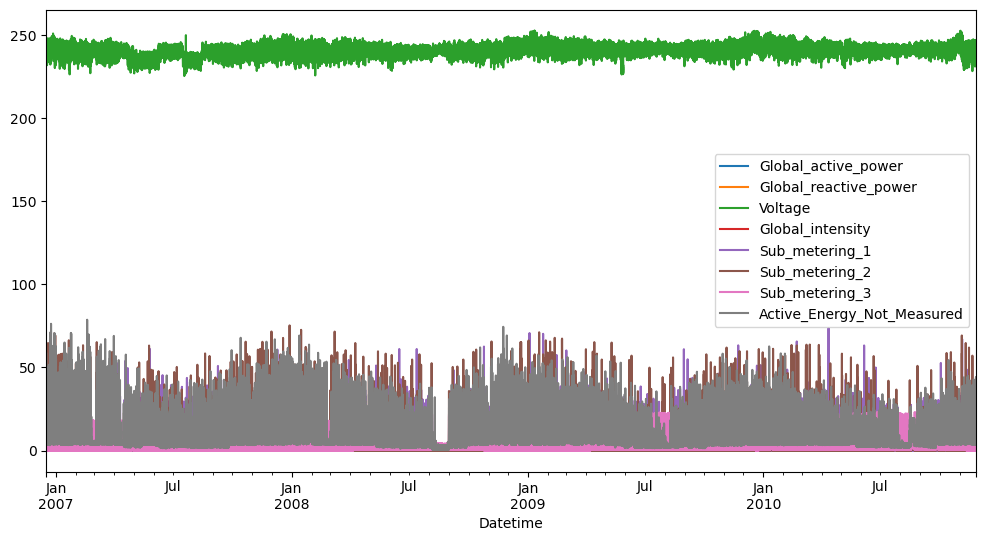

In [6]:

data_resampled.plot(figsize=(12,6))

In [7]:
data_resampled.shape

(138352, 8)

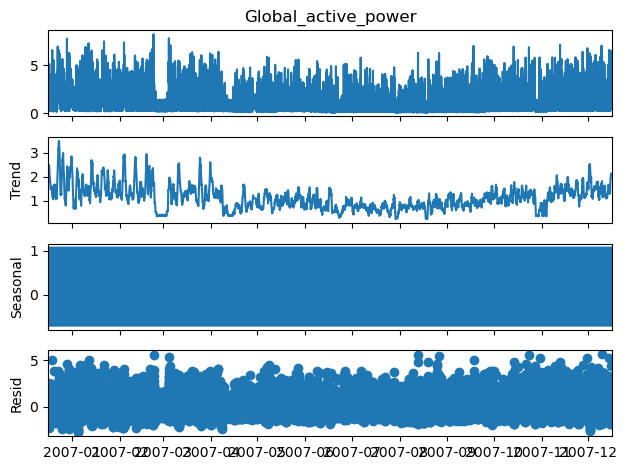

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompfreq = 6*12
results = seasonal_decompose(data_resampled["Global_active_power"][0:35000],period = 4*24)
results.plot();

In [9]:
global_dataset = data_resampled.iloc[:, :2]

In [10]:
global_dataset.shape

(138352, 2)

In [11]:

train = global_dataset.iloc[:110682]
test = global_dataset.iloc[110682:]

In [12]:
dataset_train = train.Global_active_power.values
dataset_train = np.reshape(dataset_train, (-1,1)) 
dataset_train.shape

(110682, 1)

In [13]:

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
# scaling dataset
scaled_train = scaler.fit_transform(dataset_train)
 
print(scaled_train[:5])

[[0.53125147]
 [0.47862899]
 [0.48082814]
 [0.47631988]
 [0.43478739]]


In [14]:

# Selecting Open Price values
dataset_test = test.Global_active_power.values 
# Reshaping 1D to 2D array
dataset_test = np.reshape(dataset_test, (-1,1))  
# Normalizing values between 0 and 1
scaled_test = scaler.fit_transform(dataset_test)  
print(*scaled_test[:5])

[0.03670864] [0.0283141] [0.02562085] [0.05556139] [0.06566981]


In [15]:

X_train = []
y_train = []
for i in range(50, len(scaled_train)):
    X_train.append(scaled_train[i-50:i, 0])
    y_train.append(scaled_train[i, 0])
    if i <= 51:
        print(X_train)
        print(y_train)
        print()


[array([0.53125147, 0.47862899, 0.48082814, 0.47631988, 0.43478739,
       0.35927805, 0.40451768, 0.40132891, 0.39658504, 0.38811831,
       0.37955734, 0.38045271, 0.37839494, 0.37435793, 0.37033663,
       0.34237602, 0.35373305, 0.34878497, 0.35869685, 0.34498358,
       0.2293712 , 0.21058419, 0.21510815, 0.21982061, 0.21116539,
       0.23450778, 0.26927004, 0.2567506 , 0.19245692, 0.19049339,
       0.21064702, 0.42859836, 0.41912631, 0.38970484, 0.30420509,
       0.17437678, 0.18432007, 0.17294733, 0.1795919 , 0.18760309,
       0.18183817, 0.19537865, 0.18172822, 0.1912788 , 0.18732034,
       0.31160365, 0.31721148, 0.32577245, 0.19211134, 0.19057194])]
[0.1957399349680338]

[array([0.53125147, 0.47862899, 0.48082814, 0.47631988, 0.43478739,
       0.35927805, 0.40451768, 0.40132891, 0.39658504, 0.38811831,
       0.37955734, 0.38045271, 0.37839494, 0.37435793, 0.37033663,
       0.34237602, 0.35373305, 0.34878497, 0.35869685, 0.34498358,
       0.2293712 , 0.21058419, 0.215

In [16]:

X_test = []
y_test = []
for i in range(50, len(scaled_test)):
    X_test.append(scaled_test[i-50:i, 0])
    y_test.append(scaled_test[i, 0])

In [17]:

# The data is converted to Numpy array
X_train, y_train = np.array(X_train), np.array(y_train)
 
#Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
print("X_train :",X_train.shape,"y_train :",y_train.shape)


# The data is converted to numpy array
X_test, y_test = np.array(X_test), np.array(y_test)
 
#Reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
y_test = np.reshape(y_test, (y_test.shape[0],1))
print("X_test :",X_test.shape,"y_test :",y_test.shape)

X_train : (110632, 50, 1) y_train : (110632, 1)
X_test : (27620, 50, 1) y_test : (27620, 1)


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [19]:
#Initialising the model
regressorLSTM = Sequential()

#Adding LSTM layers
regressorLSTM.add(LSTM(50, 
					return_sequences = True, 
					input_shape = (X_train.shape[1],1)))
regressorLSTM.add(LSTM(50, 
					return_sequences = False))
regressorLSTM.add(Dense(25))

#Adding the output layer
regressorLSTM.add(Dense(1))

#Compiling the model
regressorLSTM.compile(optimizer = 'adam',
					loss = 'mean_squared_error',
					metrics = ["accuracy"])

#Fitting the model
regressorLSTM.fit(X_train, 
				y_train, 
				batch_size = 1, 
				epochs = 20)
regressorLSTM.summary()


C:\Users\micha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
110632/110632 ━━━━━━━━━━━━━━━━━━━━ 1509s 14ms/step - accuracy: 4.8053e-07 - loss: 0.0047
Epoch 2/20
110632/110632 ━━━━━━━━━━━━━━━━━━━━ 1500s 14ms/step - accuracy: 5.6695e-06 - loss: 0.0041
Epoch 3/20
110632/110632 ━━━━━━━━━━━━━━━━━━━━ 1507s 14ms/step - accuracy: 1.3698e-05 - loss: 0.0041
Epoch 4/20
110632/110632 ━━━━━━━━━━━━━━━━━━━━ 1491s 13ms/step - accuracy: 2.5108e-05 - loss: 0.0040
Epoch 5/20
110632/110632 ━━━━━━━━━━━━━━━━━━━━ 1485s 13ms/step - accuracy: 3.4004e-06 - loss: 0.0040
Epoch 6/20
110632/110632 ━━━━━━━━━━━━━━━━━━━━ 1490s 13ms/step - accuracy: 4.4058e-06 - loss: 0.0039
Epoch 7/20
110632/110632 ━━━━━━━━━━━━━━━━━━━━ 1502s 14ms/step - accuracy: 6.9514e-06 - loss: 0.0039
Epoch 8/20
110632/110632 ━━━━━━━━━━━━━━━━━━━━ 1527s 14ms/step - accuracy: 4.6341e-06 - loss: 0.0039
Epoch 9/20
110632/110632 ━━━━━━━━━━━━━━━━━━━━ 1542s 14ms/step - accuracy: 1.2478e-06 - loss: 0.0038
Epoch 10/20
110632/110632 ━━━━━━━━━━━━━━━━━━━━ 1529s 14ms/step - accuracy: 1.3977e-05 - loss: 0.0038

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 95,705 (373.85 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,804 (249.24 KB)

In [22]:
y_LSTM = regressorLSTM.predict(X_test)
y_LSTM_O = scaler.inverse_transform(y_LSTM) 


 


864/864 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step


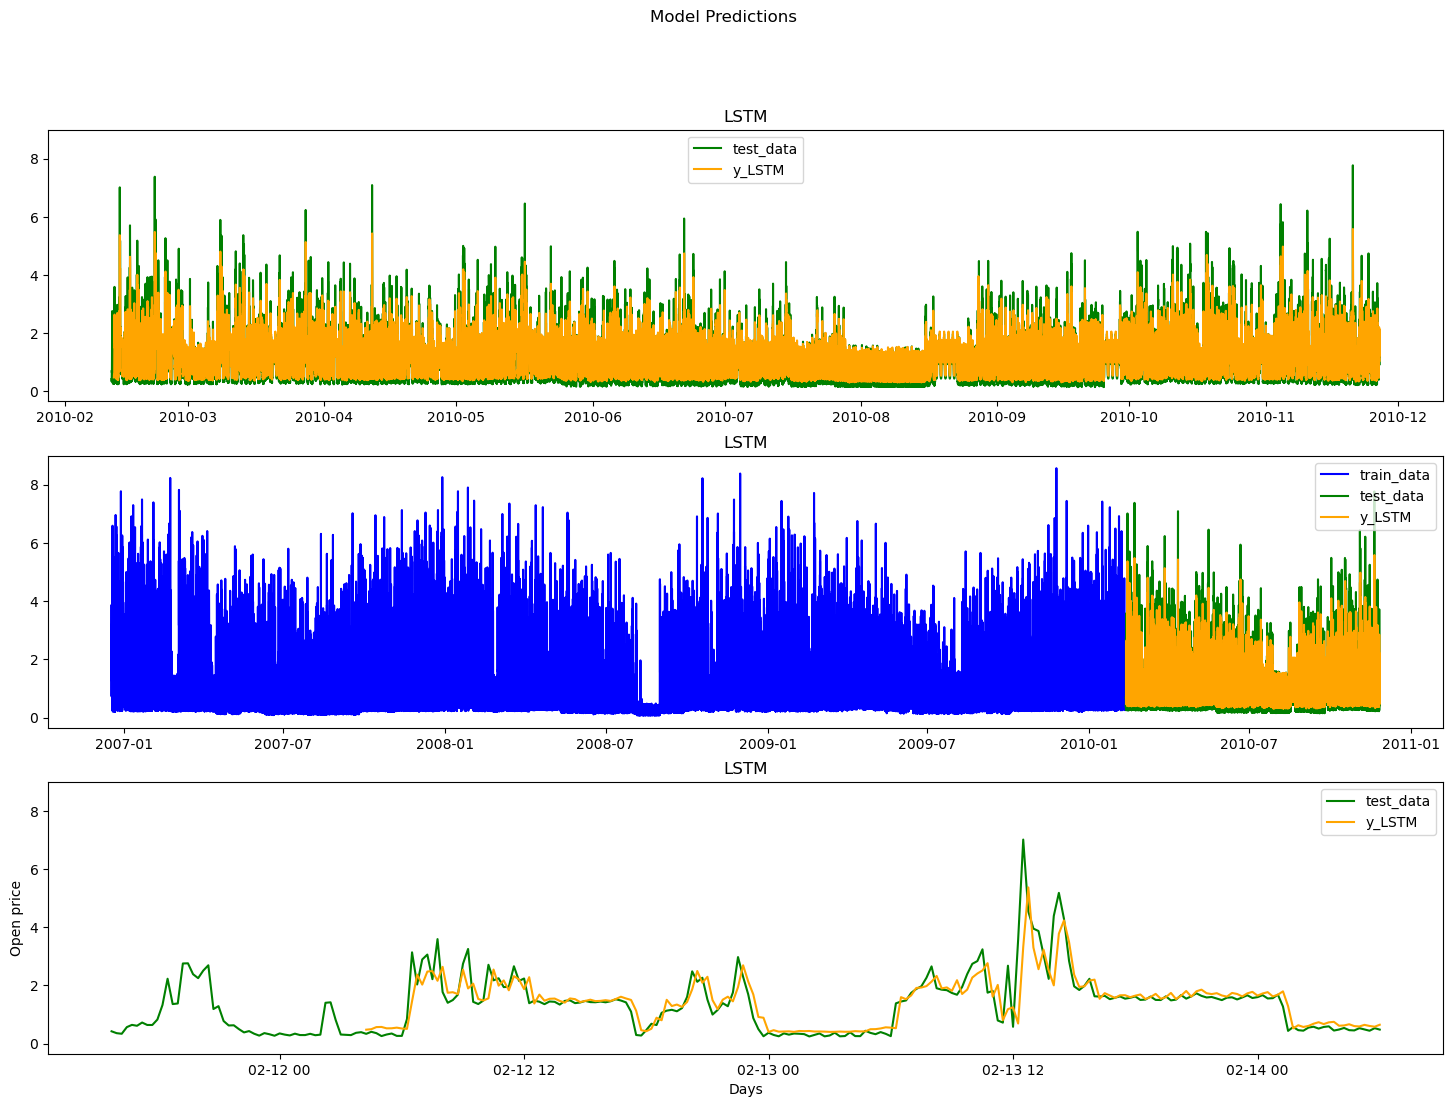

In [35]:

fig, axs = plt.subplots(3,figsize =(18,12),sharex=False, sharey=True)
fig.suptitle('Model Predictions')

#Plot for LSTM predictions
axs[1].plot(train.index[150:], train.Global_active_power[150:], label = "train_data", color = "b")
axs[1].plot(test.index, test.Global_active_power, label = "test_data", color = "g")
axs[1].plot(test.index[50:], y_LSTM_O, label = "y_LSTM", color = "orange")
axs[1].legend()
axs[1].title.set_text("LSTM")
axs[0].plot(test.index, test.Global_active_power, label = "test_data", color = "g")
axs[0].plot(test.index[50:], y_LSTM_O, label = "y_LSTM", color = "orange")
axs[0].legend()
axs[0].title.set_text("LSTM")

axs[2].plot(test.index[:250], test.Global_active_power[:250], label = "test_data", color = "g")
axs[2].plot(test.index[50:][:200], y_LSTM_O[:200], label = "y_LSTM", color = "orange")
axs[2].legend()
axs[2].title.set_text("LSTM")
    
plt.xlabel("Days")
plt.ylabel("Open price")
 
plt.show()